## Problem Statement

### Business Context "My idea of a business context"
Tuko is a media analysis firm specializing in providing data-driven insights and strategic consultation services to news organizations, advertisers, and academic entities interested in media studies. Utilizing advanced data science techniques, the company aims to offer comprehensive analysis and recommendations based on global news trends and patterns.

### Objective
The firm has access to a rich dataset comprising news articles from various global sources, website traffic data, and domain locations. This dataset is a gold mine for understanding the dynamics of news dissemination, audience engagement, and content sentiment across different regions and media platforms.  By correlating news sentiment with traffic data, Tuko can assess the impact of news events on consumer behavior and adjust their campaigns accordingly. They have engaged you as a data scientist to carry out the following:
- Perform exploratory data analysis (EDA) to uncover patterns, insights, and anomalies in the data.
- Conduct topic modeling and sentiment analysis on the news content.
- Design and implement a PostgreSQL database schema to store ML features.
- Load and manage data within PostgreSQL, using it as a feature store for ML models.


### Data Description
`data.csv:`

- article_id: Unique article id
- source_id
- source_name: Source name
- author: The author of the article
- title: The headline or title of the article.
- description: A description or snippet from the article. 
- url: The direct URL to the article. 
- url_to_image: The URL to a relevant image for the article.
- published_at: The date and time that the article was published, in UTC
- content: The unformatted content of the article, where available. This is truncated to 200 chars
- category: Search query used to fetch data
- article: Full content of that article
- title_sentiment: Sentiment of the title


`domains_location.csv:`

- SourceCommonName: Common  Domain Name (bbc.co.uk, cnn.com)
- location: Country short code (US, UK, CA)
- Country: Country name

`traffic_data.csv:`

- GlobalRank: Rank of the domain globally
- TldRank: Rank of the TLD (Top-Level Domain [.com, .org…..etc]) among other similar TLD (Top-Level Domain [.com, .org…..etc])
- Domain: 
TLD: TLD (Top-Level Domain [.com, .org…..etc])
RefSubNets: The number of Referring Subnets found for this domain in the Fresh Index.
RefIPs: The number of Referring IPs found for this domain in the Fresh Index.
IDN_Domain: Internationalized Domain Name
IDN_TLD: Internationalized Domain Name Top-Level Domain.
PrevGlobalRank: Previous Global Rank.
PrevTldRank: Previous TLD Rank.
PrevRefSubNets: Previous number of referring subnets.
PrevRefIPs: Previous number of referring IPs.

## Importing necessary libraries

In [52]:
# directory
import os, sys

# data manipulation
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#topic modelling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity

## Loading the dataset

In [2]:
trafficdf = pd.read_csv('traffic.csv')
dfs_final_merged = pd.read_csv('rating.csv')
domaindf = pd.read_csv('domains_location.csv')

## Loader.py

In [3]:
# system path
if os.path.abspath("..") not in sys.path:
    sys.path.insert(0, os.path.abspath(".."))

# importing module
from src.loader import NewsDataLoader

loader = NewsDataLoader()
news_data = loader.load_data('C:/Users/Jojo/Desktop/10A/10x/Week0-Cb/rating.csv')



## Data Overview

In [4]:
# first five rows of our rating dataset
dfs_final_merged.head()

,article_id,source_id,source_name,author,title,description,url,url_to_image,published_at,content,category,article,title_sentiment
0,81664,NaN,Forbes,"Elizabeth Brownfield, Contributor, \n Elizabet...",superstar chef yannick alléno brings refined f...,Now open in Mayfair at Four Seasons Hotel Lond...,https://www.forbes.com/sites/elizabethbrownfie...,https://imageio.forbes.com/specials-images/ima...,2023-11-01 03:27:21.000000,"Pavyllon London, at Four Seasons Hotel London ...",Monaco,"pavyllon london, at four seasons hotel london ...",Neutral
1,81667,NaN,CNA,NaN,nice claim top spot in ligue 1 with late win a...,Nice moved into provisional first place in the...,https://www.channelnewsasia.com/sport/nice-cla...,https://onecms-res.cloudinary.com/image/upload...,2023-10-27 21:28:48.000000,Nice moved into provisional first place in the...,Monaco,nice moved into provisional first place in the...,Positive
2,81694,time,Time,Christina Larson / AP,amphibians are the world’s most vulnerable spe...,"The world’s frogs, salamanders, newts, and oth...",https://time.com/6320467/amphibians-most-vulne...,https://api.time.com/wp-content/uploads/2023/1...,2023-10-04 17:36:18.000000,"The worlds frogs, salamanders, newts and other...",Madagascar,"the world’s frogs, salamanders, newts and othe...",Negative
3,81695,NaN,Phys.Org,Sara Schmidt,image: rusty red waters in madagascar,Iron-rich sediment colors the red-orange water...,https://phys.org/news/2023-10-image-rusty-red-...,https://scx2.b-cdn.net/gfx/news/2023/image-rus...,2023-10-31 18:04:02.000000,Iron-rich sediment colors the red-orange water...,Madagascar,iron-rich sediment colors the red-orange water...,Neutral
4,81703,NaN,Digital Trends,Jason Struss,everything leaving max (formerly hbo max) in n...,From Gangs of London to Fear the Walking Dead ...,https://www.digitaltrends.com/movies/everythin...,https://www.digitaltrends.com/wp-content/uploa...,2023-10-23 23:09:18.000000,"Everything ends. No, I’m not having an existen...",Madagascar,"everything ends. no, i’m not having an existen...",Neutral


In [5]:
# first five rows of our domain location dataset
domaindf.head()

,SourceCommonName,location,Country
0,00221.info,SG,Senegal
1,01net.com,FR,France
2,01net.it,IT,Italy
3,0223.com.ar,AR,Argentina
4,022china.com,CH,China


In [6]:
# first five rows of our traffic dataset
trafficdf.head()

,GlobalRank,TldRank,Domain,TLD,RefSubNets,RefIPs,IDN_Domain,IDN_TLD,PrevGlobalRank,PrevTldRank,PrevRefSubNets,PrevRefIPs
0,1,1,google.com,com,471274,2151358,google.com,com,1,1,471248,2147402
1,2,2,facebook.com,com,465424,2250631,facebook.com,com,2,2,465297,2247135
2,3,3,youtube.com,com,420579,1852995,youtube.com,com,3,3,420483,1848940
3,4,4,twitter.com,com,404985,1757127,twitter.com,com,4,4,404998,1753939
4,5,5,instagram.com,com,364746,1598085,instagram.com,com,5,5,364618,1594892


In [7]:
# shape of our data
print('There are', dfs_final_merged.shape[0], 'rows and', dfs_final_merged.shape[1], 'columns in our ratingdf', '\n')


print('There are', domaindf.shape[0], 'rows and', domaindf.shape[1], 'columns in our domaindf', '\n')

print('There are', trafficdf.shape[0], 'rows and', trafficdf.shape[1], 'columns in our trafficdf')

There are 58356 rows and 13 columns in our ratingdf 

There are 37802 rows and 3 columns in our domaindf 

There are 1000000 rows and 12 columns in our trafficdf


- There are 58356 rows and 13 columns in our ratingdf 

- There are 37802 rows and 3 columns in our domaindf 

- There are 1000000 rows and 12 columns in our trafficdf


In [8]:
print(dfs_final_merged.columns, '\n')
print(domaindf.columns, '\n')
print(trafficdf.columns, '\n')


Index(['article_id', 'source_id', 'source_name', 'author', 'title',
       'description', 'url', 'url_to_image', 'published_at', 'content',
       'category', 'article', 'title_sentiment'],
      dtype='object') 

Index(['SourceCommonName', 'location', 'Country'], dtype='object') 

Index(['GlobalRank', 'TldRank', 'Domain', 'TLD', 'RefSubNets', 'RefIPs',
       'IDN_Domain', 'IDN_TLD', 'PrevGlobalRank', 'PrevTldRank',
       'PrevRefSubNets', 'PrevRefIPs'],
      dtype='object') 



In [9]:
# checking data types of our columns
dfs_final_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58356 entries, 0 to 58355
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   article_id       58356 non-null  int64 
 1   source_id        17771 non-null  object
 2   source_name      58356 non-null  object
 3   author           56193 non-null  object
 4   title            58356 non-null  object
 5   description      58346 non-null  object
 6   url              58356 non-null  object
 7   url_to_image     54905 non-null  object
 8   published_at     58356 non-null  object
 9   content          58356 non-null  object
 10  category         58335 non-null  object
 11  article          58356 non-null  object
 12  title_sentiment  58356 non-null  object
dtypes: int64(1), object(12)
memory usage: 5.8+ MB


In [10]:
domaindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37802 entries, 0 to 37801
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   SourceCommonName  37802 non-null  object
 1   location          37802 non-null  object
 2   Country           37801 non-null  object
dtypes: object(3)
memory usage: 886.1+ KB


In [11]:
trafficdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 12 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   GlobalRank      1000000 non-null  int64 
 1   TldRank         1000000 non-null  int64 
 2   Domain          1000000 non-null  object
 3   TLD             1000000 non-null  object
 4   RefSubNets      1000000 non-null  int64 
 5   RefIPs          1000000 non-null  int64 
 6   IDN_Domain      1000000 non-null  object
 7   IDN_TLD         1000000 non-null  object
 8   PrevGlobalRank  1000000 non-null  int64 
 9   PrevTldRank     1000000 non-null  int64 
 10  PrevRefSubNets  1000000 non-null  int64 
 11  PrevRefIPs      1000000 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 91.6+ MB


- In the ratingdf, article_id column is on integer data type; The rest are of categorical data type.
- In the domaindf, all columns are of categorical data type.
- In the trafficdf, domain, tld, idn_domain, idn_tld columns are of categorical data type; the rest are numerical.

## Merging of datasets

In [12]:
# Merge Traffic Data and Domains Location Data on the common column
dfs_merged = pd.merge(trafficdf, domaindf, left_on='Domain', right_on='SourceCommonName', how='inner')

# Display the head of the merged dataset to confirm the merge
dfs_merged.head()

,GlobalRank,TldRank,Domain,TLD,RefSubNets,RefIPs,IDN_Domain,IDN_TLD,PrevGlobalRank,PrevTldRank,PrevRefSubNets,PrevRefIPs,SourceCommonName,location,Country
0,1,1,google.com,com,471274,2151358,google.com,com,1,1,471248,2147402,google.com,US,United States
1,2,2,facebook.com,com,465424,2250631,facebook.com,com,2,2,465297,2247135,facebook.com,VM,Vietnam
2,3,3,youtube.com,com,420579,1852995,youtube.com,com,3,3,420483,1848940,youtube.com,US,United States
3,7,7,apple.com,com,263655,804726,apple.com,com,7,7,263416,801213,apple.com,US,United States
4,8,8,microsoft.com,com,260546,739096,microsoft.com,com,8,8,260326,736093,microsoft.com,US,United States


In [13]:
# Extract domain names from URLs in the Rating Data
dfs_final_merged['extracted_domain'] = dfs_final_merged['url'].str.extract('(?:https?://)?(?:www\.)?([^/]+)')

# Display the unique extracted domains to see the format and check feasibility of matching
df_rating_unique_domains = dfs_final_merged['extracted_domain'].unique()
print(df_rating_unique_domains[:30])  # Display first 30 unique domains for brevity

['forbes.com' 'channelnewsasia.com' 'time.com' 'phys.org'
 'digitaltrends.com' 'aljazeera.com' 'bbc.co.uk' 'deadline.com'
 'euronews.com' 'rt.com' 'punchng.com' 'ibtimes.com' 'indianexpress.com'
 'etfdailynews.com' 'abcnews.go.com' 'globalsecurity.org'
 'marketscreener.com' 'timesofindia.indiatimes.com' 'globenewswire.com'
 'economictimes.indiatimes.com' 'cnalifestyle.channelnewsasia.com'
 'cnn.com' 'businessinsider.com' 'gizmodo.com' 'wired.com' 'theverge.com'
 'npr.org' 'boingboing.net' 'androidcentral.com' 'readwrite.com']


In [14]:
# Merge the previously merged dataset with Rating Data on the domain names
dfs_final_merged = pd.merge(dfs_merged, dfs_final_merged, left_on='Domain', right_on='extracted_domain', how='inner')

# Display the head of the final merged dataset to confirm the merge
dfs_final_merged.head()

,GlobalRank,TldRank,Domain,TLD,RefSubNets,RefIPs,IDN_Domain,IDN_TLD,PrevGlobalRank,PrevTldRank,...,title,description,url,url_to_image,published_at,content,category,article,title_sentiment,extracted_domain
0,64,45,forbes.com,com,95914,239145,forbes.com,com,62,43,...,superstar chef yannick alléno brings refined f...,Now open in Mayfair at Four Seasons Hotel Lond...,https://www.forbes.com/sites/elizabethbrownfie...,https://imageio.forbes.com/specials-images/ima...,2023-11-01 03:27:21.000000,"Pavyllon London, at Four Seasons Hotel London ...",Monaco,"pavyllon london, at four seasons hotel london ...",Neutral,forbes.com
1,64,45,forbes.com,com,95914,239145,forbes.com,com,62,43,...,investing in girls and their futures,Investing in girls is not only the right thing...,https://www.forbes.com/sites/unicefusa/2023/10...,https://imageio.forbes.com/specials-images/ima...,2023-10-11 16:16:40.000000,Investing in girls is not only the right thing...,Madagascar,"in october 2023, unicef education officer beno...",Neutral,forbes.com
2,64,45,forbes.com,com,95914,239145,forbes.com,com,62,43,...,setting intentional climate solution goals as ...,A growing number of companies are using a seem...,https://www.forbes.com/sites/forbesnonprofitco...,https://imageio.forbes.com/specials-images/ima...,2023-10-18 11:00:00.000000,Dan Lambe is the CEO of the Arbor Day Foundati...,Madagascar,dan lambe is the ceo of the arbor day foundati...,Neutral,forbes.com
3,64,45,forbes.com,com,95914,239145,forbes.com,com,62,43,...,10 of the best matcha powders that are smooth ...,Depending on how you plan to use it and what y...,https://www.forbes.com/sites/forbes-personal-s...,https://imageio.forbes.com/specials-images/ima...,2023-10-30 19:23:39.000000,Matcha has made its way to nearly every coffee...,Madagascar,matcha has made its way to nearly every coffee...,Positive,forbes.com
4,64,45,forbes.com,com,95914,239145,forbes.com,com,62,43,...,20 delicious dishes to enjoy while celebrating...,It's a perfect time to show our favorite pasta...,https://www.forbes.com/sites/alywalansky/2023/...,https://imageio.forbes.com/specials-images/ima...,2023-10-16 12:36:41.000000,Theres so many ways to enjoy pasta. Some may e...,Madagascar,there’s so many ways to enjoy pasta. some may ...,Positive,forbes.com


In [53]:
dfs_final_merged.shape

(47086, 35)

In [16]:
# Save the final merged dataset to a CSV file
#dfs_final_merged.to_csv('final_merged_dataset.csv', index=False)
#print('The final merged dataset has been saved as final_merged_dataset.csv.')

- Our merged dataset has 47,086 rows and 35 columns.

## Exploratory Data Analysis (EDA)

##### Websites that have the largest count of news articles

In [17]:
# 1a
dfs_final_merged['source_name'].value_counts()[:10]

source_name
ETF Daily News                  16746
GlobeNewswire                    5423
Globalsecurity.org               3119
Forbes                           2784
BBC News                         2113
Business Insider                 2034
The Punch                        1800
Al Jazeera English               1664
Phys.Org                         1263
International Business Times     1207
Name: count, dtype: int64

In [18]:
#1b
dfs_final_merged['source_name'].value_counts()[-10:]

source_name
Boing Boing                    713
CNA                            652
Time                           600
Android Central                522
Gizmodo.com                    388
Euronews                       286
Wired                          270
CNN                            267
The Verge                      214
AllAfrica - Top Africa News     20
Name: count, dtype: int64

- ETFDaily, Globenewswire and Globalsecurity.org are the websites with the largest number of news articles.
- All Africa, CNN, The verge are the websites with the smallest number of articles.

##### Websites with the highest numbers of visitors traffic 

In [19]:
#2a
from urllib.parse import urlparse

# Function to extract the base domain from a URL
def extract_domain(url):
    try:
        parsed_url = urlparse(url)
        return parsed_url.netloc
    except:
        return "Invalid URL"

# Apply the function to the 'url' column
dfs_final_merged['base_url'] = dfs_final_merged['url'].apply(extract_domain)

# Count the occurrences of each base_url to approximate traffic
top_websites = dfs_final_merged['base_url'].value_counts().head(10)

print(top_websites)


base_url
www.etfdailynews.com       16746
www.globenewswire.com       5423
www.globalsecurity.org      3119
www.forbes.com              2784
www.businessinsider.com     2034
www.bbc.co.uk               2032
punchng.com                 1800
www.aljazeera.com           1664
phys.org                    1263
www.ibtimes.com             1207
Name: count, dtype: int64


In [20]:
#2b
from urllib.parse import urlparse

# Function to extract the base domain from a URL
def extract_domain(url):
    try:
        parsed_url = urlparse(url)
        return parsed_url.netloc
    except:
        return "Invalid URL"

# Apply the function to the 'url' column
dfs_final_merged['base_url'] = dfs_final_merged['url'].apply(extract_domain)

# Count the occurrences of each base_url to approximate traffic
bottom_websites = dfs_final_merged['base_url'].value_counts().tail(10)

print(bottom_websites)


base_url
www.channelnewsasia.com    652
time.com                   600
www.androidcentral.com     522
gizmodo.com                388
www.euronews.com           286
www.wired.com              270
www.cnn.com                267
www.theverge.com           214
www.bbc.com                 81
allafrica.com               20
Name: count, dtype: int64


- ETFdaily, globalnewswire and global security org have the highest number of visitors traffic
- Allafrica, bbc and the verge have the least number of visitors traffic.

##### Countries with the highest number of news media organisations (represented by domains in the data)

In [21]:
#3a
domaindf['Country'].value_counts()[:10]

Country
United States     14111
United Kingdom     1950
Italy              1810
France             1041
Russia             1024
Canada              887
Germany             884
China               780
Turkey              725
India               686
Name: count, dtype: int64

In [22]:
#3b
domaindf['Country'].value_counts()[-10:]

Country
Greenland         1
Guernsey          1
Isle of Man       1
Cook Islands      1
Guinea-Bissau     1
Micronesia        1
Aruba             1
American Samoa    1
Guadeloupe        1
Saint Helena      1
Name: count, dtype: int64

- US, UK, Italy is where most media companies originate from.

##### Countries that have many articles written about them - the content of the news is about that country

In [23]:
#4a
import pandas as pd
import nltk
from collections import Counter

# Assuming ratingdf and domaindf are already loaded
# Prepare the list of unique country names from domaindf
unique_countries = domaindf['Country'].dropna().unique()

# Function to count country mentions in text
def count_country_mentions(text, countries):
    text = text.lower()
    return Counter(country for country in countries if country.lower() in text)

# Apply function to each article's content
dfs_final_merged['country_mentions'] = dfs_final_merged['article'].apply(lambda x: count_country_mentions(x, unique_countries))

# Aggregate all counts
total_country_mentions = sum(dfs_final_merged['country_mentions'], Counter())

# Show results
print(total_country_mentions.most_common(10))


[('United States', 11254), ('Canada', 7346), ('China', 4436), ('Israel', 4403), ('India', 3543), ('Russia', 3386), ('Ukraine', 2730), ('Oman', 2702), ('Australia', 2529), ('Japan', 2320)]


- Most articles mention US followed by Canada.

##### Websites that reported (the news content) about Africa, US, China, EU, Russia, Ukraine, Middle East?


In [24]:
domaindf['Country'].nunique()

225

In [25]:
# grouping countries
Africa = ["Algeria", "Angola", "Benin", "Botswana", "Burkina Faso", "Burundi", "Cabo Verde", "Cameroon", "Central African Republic", "Chad", "Comoros", "Congo",
"Democratic Republic of the Congo", "Djibouti", "Egypt", "Equatorial Guinea", "Eritrea", "Ethiopia", "Eswatini", "Gabon", "Gambia", "Ghana", "Guinea", 
"Guinea-Bissau", "Ivory Coast", "Kenya", "Lesotho", "Liberia", "Libya", "Madagascar", "Malawi", "Mali", "Mauritania", "Mauritius", "Morocco", 
"Mozambique", "Namibia", "Niger", "Nigeria", "Rwanda", "São Tomé and Príncipe", "Senegal", "Seychelles", "Sierra Leone", "Somalia", "South Africa", 
"South Sudan", "Sudan", "Tanzania", "Togo", "Tunisia", "Uganda", "Zambia", "Zimbabwe"]

Europe= ["Albania", "Andorra", "Armenia", "Austria", "Azerbaijan", "Belarus", "Belgium", "Bosnia and Herzegovina", "Bulgaria", "Croatia", 
"Cyprus", "Czech Republic", "Denmark", "Estonia", "Finland", "France", "Georgia", "Germany", "Greece", "Hungary", "Iceland",
"Ireland", "Italy", "Kosovo", "Latvia", "Liechtenstein", "Lithuania", "Luxembourg", "Malta", "Moldova", "Monaco", "Montenegro",
"Netherlands", "North Macedonia", "Norway", "Poland", "Portugal", "Romania", "Russia", "San Marino", "Serbia", "Slovakia", "Slovenia", "Spain",
"Sweden", "Switzerland", "Turkey", "Ukraine", "United Kingdom"]

Middle_East =["Bahrain", "Cyprus", "Egypt", "Iran", "Iraq", "Israel", "Jordan", "Kuwait", "Lebanon", "Oman", "Qatar", "Saudi Arabia", "Syria",
"Turkey", "United Arab Emirates", "Yemen"]

United_States = ['United States']
China = ['China']
Russia = ['Russia']
Ukraine = ['Ukraine']


region_countries = {
    'Africa': Africa,
    'EU': Europe,
    'Middle East': Middle_East,
    'US': United_States,
    'China': China,
    'Russia': Russia,
    'Ukraine': Ukraine
}

def count_region_mentions(text, regions):
    text = text.lower()
    mentions = Counter()
    for region, countries in regions.items():
        if any(country.lower() in text for country in countries):
            mentions[region] += 1
    return mentions

# Assuming the 'article' column contains the text data
dfs_final_merged['region_mentions'] = dfs_final_merged['article'].apply(lambda x: count_region_mentions(str(x), region_countries))

# Extract domain as a proxy for source name
dfs_final_merged['source_domain'] = dfs_final_merged['url'].apply(lambda url: urlparse(url).netloc)

# Sum all mentions by domain
domain_mentions = dfs_final_merged.groupby('source_domain')['region_mentions'].sum()

# Function to find top and bottom 10 domains for a region
def top_bottom_domains(domain_mentions, region):
    region_series = pd.Series({domain: mentions[region] for domain, mentions in domain_mentions.items()})
    return region_series.nlargest(10), region_series.nsmallest(10)

# Get top and bottom 10 for Africa
top_africa, bottom_africa = top_bottom_domains(domain_mentions, 'Africa')
print("Top 10 sources for Africa: \n", top_africa)
print("\nBottom 10 sources for Africa:", bottom_africa)


Top 10 sources for Africa: 
 punchng.com               1493
www.globalsecurity.org     756
www.aljazeera.com          547
www.globenewswire.com      452
www.bbc.co.uk              396
www.etfdailynews.com       389
www.rt.com                 311
www.ibtimes.com            295
www.forbes.com             285
phys.org                   209
dtype: int64

Bottom 10 sources for Africa: www.androidcentral.com     9
www.bbc.com               11
www.theverge.com          11
allafrica.com             16
www.wired.com             20
gizmodo.com               27
www.digitaltrends.com     34
boingboing.net            36
www.cnn.com               68
www.euronews.com          83
dtype: int64


In [26]:
# Get top and bottom 10 for US
top_us, bottom_us = top_bottom_domains(domain_mentions, 'US')
print("Top 10 sources for US: \n", top_us)
print("/nBottom 10 sources for US:", bottom_us)


Top 10 sources for US: 
 www.etfdailynews.com       6733
www.globenewswire.com      1500
www.globalsecurity.org      936
www.aljazeera.com           510
www.ibtimes.com             257
www.forbes.com              237
www.npr.org                 134
phys.org                    125
www.businessinsider.com     124
punchng.com                  88
dtype: int64
/nBottom 10 sources for US: allafrica.com              0
www.bbc.com                3
www.theverge.com           5
www.androidcentral.com     9
www.digitaltrends.com     17
gizmodo.com               19
www.wired.com             24
deadline.com              34
www.euronews.com          36
boingboing.net            43
dtype: int64


In [27]:
# Get top and bottom 10 for China
top_eu, bottom_eu = top_bottom_domains(domain_mentions, 'China')
print("Top 10 sources for China: \n", top_eu)
print("\nBottom 10 sources for China:", bottom_eu)


Top 10 sources for China: 
 www.etfdailynews.com       1178
www.globenewswire.com       847
www.globalsecurity.org      646
www.ibtimes.com             210
www.aljazeera.com           188
www.rt.com                  178
www.forbes.com              174
www.businessinsider.com     140
www.channelnewsasia.com     128
phys.org                    112
dtype: int64

Bottom 10 sources for China: allafrica.com              0
www.bbc.com                5
www.theverge.com           8
boingboing.net             9
www.digitaltrends.com     12
gizmodo.com               13
www.wired.com             13
www.androidcentral.com    23
www.euronews.com          39
www.cnn.com               40
dtype: int64


In [28]:
# Get top and bottom 10 for EU
top_eu, bottom_eu = top_bottom_domains(domain_mentions, 'EU')
print("Top 10 sources for EU: \n", top_eu)
print("\nBottom 10 sources for EU:", bottom_eu)


Top 10 sources for EU: 
 www.etfdailynews.com       2320
www.globalsecurity.org     1622
www.globenewswire.com      1593
www.rt.com                  791
www.aljazeera.com           648
www.forbes.com              589
www.bbc.co.uk               568
www.businessinsider.com     557
www.ibtimes.com             500
phys.org                    374
dtype: int64

Bottom 10 sources for EU: allafrica.com               3
www.theverge.com           11
www.androidcentral.com     19
www.wired.com              38
gizmodo.com                39
www.bbc.com                39
www.digitaltrends.com      54
boingboing.net             69
www.cnn.com               103
indianexpress.com         145
dtype: int64


In [29]:
# Example usage: Get top and bottom 10 for Russia
top_russia, bottom_russia = top_bottom_domains(domain_mentions, 'Russia')
print("Top 10 sources for Russia: \n", top_russia)
print("\nBottom 10 sources for Russia:", bottom_russia)


Top 10 sources for Russia: 
 www.globalsecurity.org     1013
www.rt.com                  627
www.businessinsider.com     304
www.aljazeera.com           267
www.ibtimes.com             214
www.globenewswire.com       196
www.bbc.co.uk               144
www.euronews.com             88
www.forbes.com               78
time.com                     66
dtype: int64

Bottom 10 sources for Russia: allafrica.com              0
www.androidcentral.com     0
www.theverge.com           2
www.digitaltrends.com      4
boingboing.net             8
gizmodo.com                8
www.bbc.com                9
www.wired.com              9
deadline.com              26
www.cnn.com               31
dtype: int64


In [30]:
# Example usage: Get top and bottom 10 for Middle East
top_me, bottom_me = top_bottom_domains(domain_mentions, 'Middle East')
print("Top 10 sources for Middle East: \n", top_me)
print("\nBottom 10 sources for Middle East:", bottom_me)


Top 10 sources for Middle East: 
 www.globalsecurity.org     1583
www.aljazeera.com          1041
www.bbc.co.uk               667
www.businessinsider.com     633
www.globenewswire.com       571
www.ibtimes.com             455
www.etfdailynews.com        454
www.rt.com                  447
www.forbes.com              431
www.npr.org                 402
dtype: int64

Bottom 10 sources for Middle East: allafrica.com               2
www.androidcentral.com      4
www.theverge.com           19
www.wired.com              23
www.bbc.com                25
gizmodo.com                44
www.euronews.com          105
www.cnn.com               112
boingboing.net            113
www.digitaltrends.com     125
dtype: int64


- Globenewswire seems to be a site that mentions US, UK, Africa, Middle East relatively frequently.
- AlJazeera mentions Middle East in its articles quite a lot.

##### 

Sentiment counts with mean and median:
title_sentiment               Negative  Neutral  Positive  Total         Mean  \
source_name                                                                     
ABC News                           726     1193       139   2058   686.000000   
Al Jazeera English                 706      927        31   1664   554.666667   
AllAfrica - Top Africa News          8       12         0     20     6.666667   
Android Central                     38      212       272    522   174.000000   
BBC News                           854     1185        74   2113   704.333333   
Boing Boing                        250      293       170    713   237.666667   
Business Insider                   890      907       237   2034   678.000000   
CNA                                126      462        86    674   224.666667   
CNN                                102      142        23    267    89.000000   
Deadline                            84      794        54    932   310

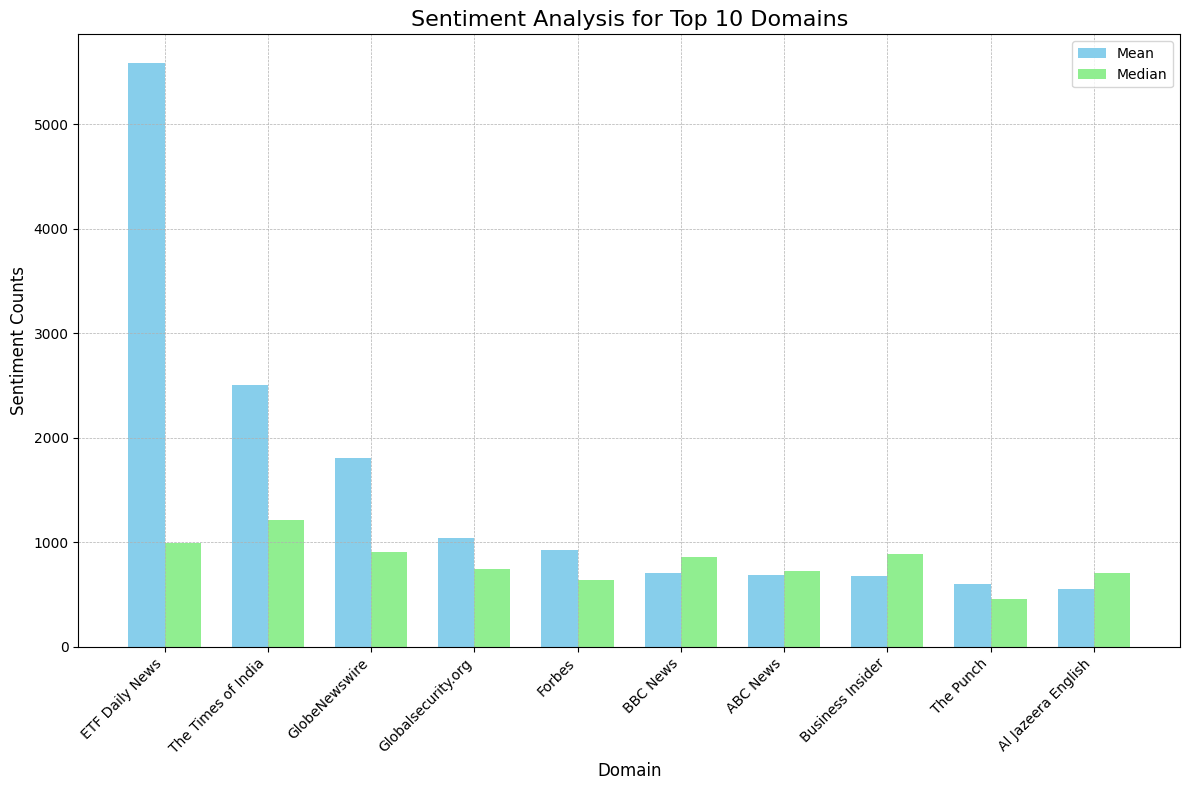

In [31]:
# Importing custom utilities
from src.utils import website_sentiment_distribution
from src.loader import NewsDataLoader



# Calculate sentiment distribution for websites
sentiment_counts = website_sentiment_distribution(news_data)

# Sort to find top domains based on total sentiment counts
top_domains = sentiment_counts.sort_values(by='Total', ascending=False).head(10)

# Function to plot grouped bar charts for sentiment analysis
def plot_grouped_sentiment(data, columns, title):
    # Set up the matplotlib figure and axes
    fig, ax = plt.subplots(figsize=(12, 8))
    bar_width = 0.35  # width of bars
    
    # Index for the bar positions
    index = np.arange(len(data))
    
    # Plotting
    bars1 = ax.bar(index, data[columns[0]], bar_width, label='Mean', color='skyblue')
    bars2 = ax.bar(index + bar_width, data[columns[1]], bar_width, label='Median', color='lightgreen')
    
    # Adding labels and title
    ax.set_xlabel('Domain', fontsize=12)
    ax.set_ylabel('Sentiment Counts', fontsize=12)
    ax.set_title(title, fontsize=16)
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(data.index, rotation=45, ha='right', fontsize=10)
    
    # Adding a legend
    ax.legend()
    
    # Show grid
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # Tight layout often provides a better fit
    plt.tight_layout()
    plt.show()

# Plot mean and median sentiment counts for the top domains
plot_grouped_sentiment(top_domains, ['Mean', 'Median'], 'Sentiment Analysis for Top 10 Domains')

##### How similar are the raw message lengths across sites? Check the distribution among sites


<Figure size 1200x800 with 0 Axes>

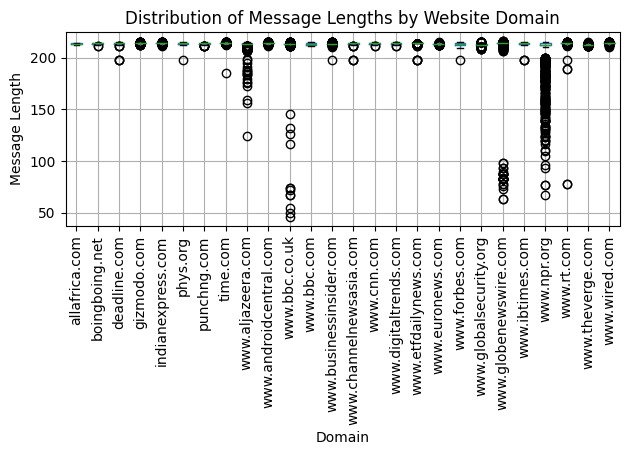

In [32]:
# Calculate the length of each article/message in the DataFrame
dfs_final_merged['message_length'] = dfs_final_merged['content'].apply(len)  # Assuming 'content' holds the text; replace with 'article' if necessary

# Extract the base domain from URLs to use as the grouping variable
dfs_final_merged['base_domain'] = dfs_final_merged['url'].apply(lambda x: x.split('/')[2] if pd.notna(x) else None)

# Group by the base domain and describe the statistics of message lengths
lengths_by_domain = dfs_final_merged.groupby('base_domain')['message_length'].describe()

# Visualize the distribution of message lengths for each domain using a boxplot
plt.figure(figsize=(12, 8))
dfs_final_merged.boxplot(column='message_length', by='base_domain', rot=45)
plt.title('Distribution of Message Lengths by Website Domain')
plt.suptitle('')  # Remove the default subtitle to clean up the plot
plt.xlabel('Domain')
plt.ylabel('Message Length')
plt.xticks(rotation=90)  # Rotate domain names for better readability
plt.tight_layout()  # Adjust layout to make room for domain labels
plt.show()


- Distribution of message length by website domain does not vary much, however there are some outliers.

C:\Users\Jojo\AppData\Local\Temp\ipykernel_33112\3132162652.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
c:\Users\Jojo\Desktop\10A\10x\myenv\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Jojo\Desktop\10A\10x\myenv\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\Jojo\Desktop\10A\10x\myenv\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tu

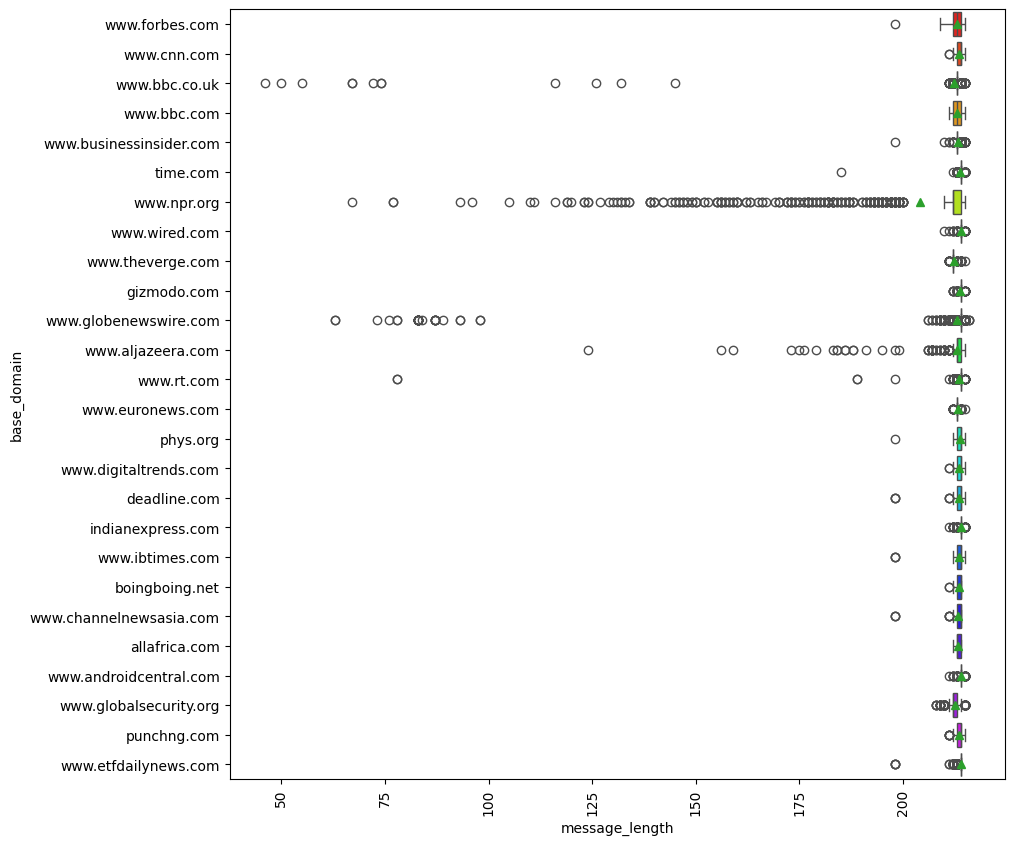

In [33]:
plt.figure(figsize=(10, 10))
sns.boxplot(
    data=dfs_final_merged, x='message_length', y="base_domain", palette="gist_rainbow", showmeans=True
)
plt.xticks(rotation=90)
plt.show()

## ML

##### Keyword Extraction

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Selecting the 'content' column and dropping any missing values
content_data = dfs_final_merged['content'].dropna()

# Initializing the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=100, stop_words='english')

# Fitting and transforming the 'content' data
tfidf_matrix = tfidf_vectorizer.fit_transform(content_data)

# Getting feature names to use as keywords
keywords = tfidf_vectorizer.get_feature_names_out()

print('TF-IDF Keywords extracted:', keywords)

TF-IDF Keywords extracted: ['00' '10' '11' '13' '13f' '15' '16' '20' '2023' '2nd' 'according' 'amp'
 'analysts' 'announced' 'bank' 'billion' 'business' 'buy' 'capital'
 'chars' 'com' 'company' 'corp' 'day' 'disclosure' 'earnings' 'exchange'
 'filing' 'financial' 'firm' 'form' 'free' 'friday' 'gaza' 'getty'
 'global' 'globe' 'group' 'high' 'holdings' 'images' 'international'
 'investment' 'investors' 'israel' 'issued' 'li' 'llc' 'low' 'management'
 'market' 'minister' 'monday' 'morning' 'nasdaq' 'national' 'new' 'news'
 'newswire' 'nov' 'november' 'nyse' 'october' 'people' 'position'
 'president' 'price' 'published' 'quarter' 'rating' 'recent' 'released'
 'report' 'reports' 'research' 'said' 'sec' 'second' 'securities' 'share'
 'shares' 'short' 'stake' 'state' 'states' 'stock' 'target' 'thursday'
 'today' 'traded' 'trading' 'tse' 'tuesday' 'ul' 'united' 'wednesday'
 'week' 'world' 'year' 'york']


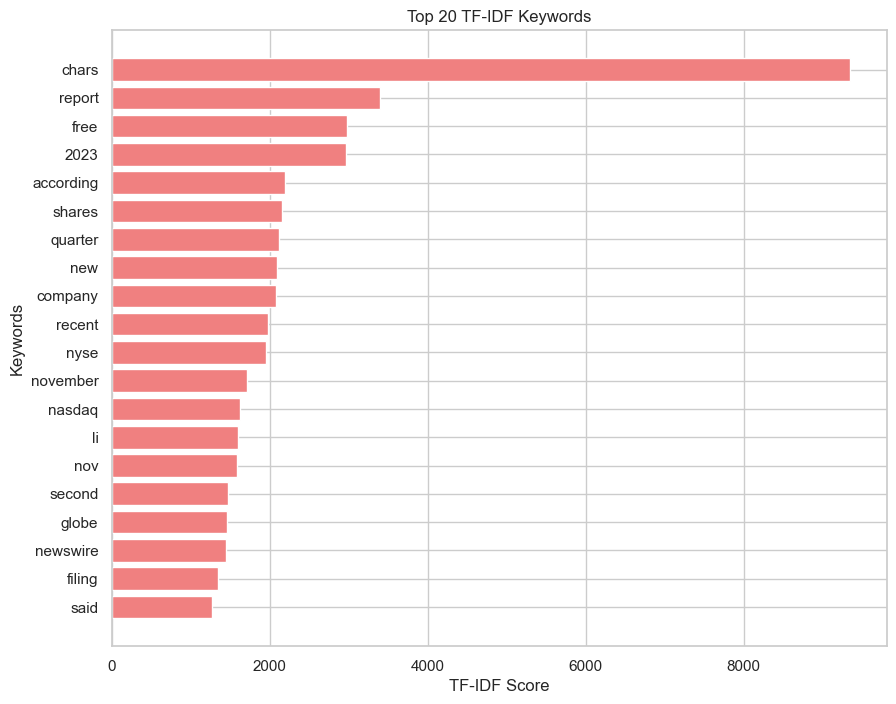

In [57]:
# visualization
# Summing up the TF-IDF scores for each keyword
sums = tfidf_matrix.sum(axis=0)
data = []
for col, term in enumerate(keywords):
    data.append((term, sums[0,col]))

# Sorting the data by TF-IDF scores
data = sorted(data, key=lambda x: x[1], reverse=True)

# Preparing the plot
keywords, scores = zip(*data)
plt.figure(figsize=(10, 8), facecolor='white')
plt.barh(keywords[:20], scores[:20], color='lightcoral')
plt.xlabel('TF-IDF Score')
plt.ylabel('Keywords')
plt.title('Top 20 TF-IDF Keywords')
plt.gca().invert_yaxis()
plt.show()

- The top 5 keywords are: chars, report, free, 2023 and according.

##### How similar are keywords in the headline/title compared to keywords in the news body across sites?

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def extract_keywords_tfidf(data, column, max_features=100):
    tfidf_vectorizer = TfidfVectorizer(max_features=max_features, stop_words='english')
    tfidf_matrix = tfidf_vectorizer.fit_transform(data[column].dropna())
    return tfidf_matrix

title_tfidf = extract_keywords_tfidf(dfs_final_merged, 'title')
content_tfidf = extract_keywords_tfidf(dfs_final_merged, 'content')

# Calculate similarity
similarity_scores = cosine_similarity(title_tfidf, content_tfidf)

# Average similarity across all articles
average_similarity = np.mean(similarity_scores)
print('Average similarity score:', average_similarity)

Average similarity score: 0.026437723399909175


In [44]:
# Dropping missing values in 'title' and 'content'
df_filtered = dfs_final_merged.dropna(subset=['title', 'content'])

# Initializing the TF-IDF Vectorizer
tfidf_vectorizer_titles = TfidfVectorizer(max_features=50, stop_words='english')
tfidf_vectorizer_content = TfidfVectorizer(max_features=50, stop_words='english')

# Fitting and transforming the 'title' and 'content' datas
tfidf_titles = tfidf_vectorizer_titles.fit_transform(df_filtered['title'])
tfidf_content = tfidf_vectorizer_content.fit_transform(df_filtered['content'])

# Calculating cosine similarity between title and content keywords for each article
similarities = [cosine_similarity(tfidf_titles[i], tfidf_content[i])[0][0] for i in range(tfidf_titles.shape[0])]

# Adding similarity scores to the dataframe
df_filtered['keyword_similarity'] = similarities

# Grouping by source and calculating average similarity
similarity_by_source = df_filtered.groupby('source_name')['keyword_similarity'].mean()

print(similarity_by_source)

source_name
Al Jazeera English              0.026487
AllAfrica - Top Africa News     0.000000
Android Central                 0.003673
BBC News                        0.017846
Boing Boing                     0.005647
Business Insider                0.018961
CNA                             0.031425
CNN                             0.026519
Deadline                        0.028791
Digital Trends                  0.008941
ETF Daily News                  0.100094
Euronews                        0.032607
Forbes                          0.014561
Gizmodo.com                     0.011377
Globalsecurity.org              0.038113
GlobeNewswire                   0.089291
International Business Times    0.026239
NPR                             0.010364
Phys.Org                        0.007203
RT                              0.009809
The Indian Express              0.031742
The Punch                       0.027394
The Verge                       0.016317
Time                            0.023544
Wire

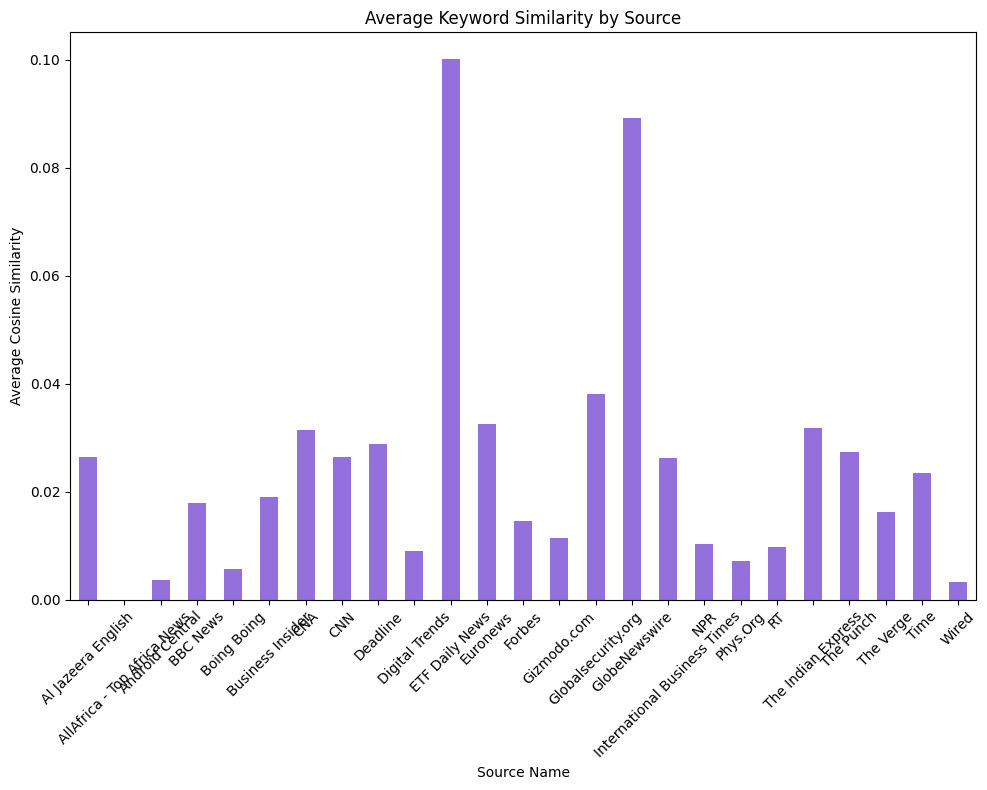

In [45]:
plt.figure(figsize=(10, 8), facecolor='white')
similarity_by_source.plot(kind='bar', color='mediumpurple')
plt.title('Average Keyword Similarity by Source')
plt.xlabel('Source Name')
plt.ylabel('Average Cosine Similarity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- An average cosine similarity score of 0.026437723399909175, indicates a very low degree of similarity between the vectors being compared.
- Keywords in the headline/title are not that similar compared to keywords in the news body across sites

##### Topic Modelling

In [48]:
# Preprocessing the text data
# Removing special characters and stopwords
#content_data = dfs_final_merged['content'].dropna().str.replace('[^\w\s]', '', regex=True).str.lower()

# Vectorizing the text data
vectorizer = CountVectorizer(stop_words='english', max_features=1000)
document_term_matrix = vectorizer.fit_transform(content_data)

# Applying LDA
lda = LatentDirichletAllocation(n_components=10, random_state=0)
lda.fit(document_term_matrix)

# Displaying topics
words = vectorizer.get_feature_names_out()
topics = {}
for topic_idx, topic in enumerate(lda.components_):
    topics[topic_idx] = [words[i] for i in topic.argsort()[:-11:-1]]

print(topics)

{0: ['chars', 'gaza', 'israel', '2023', 'said', 'people', 'israeli', 'hamas', 'november', 'war'], 1: ['according', 'recent', 'chars', 'quarter', 'report', 'free', 'filing', 'company', 'second', 'shares'], 2: ['free', 'report', 'chars', 'shares', 'reports', 'quarter', 'holdings', 'owned', 'firm', 'fund'], 3: ['2023', 'nov', 'chars', 'globe', 'newswire', 'market', 'global', 'billion', 'report', 'company'], 4: ['earnings', 'chars', 'company', 'report', 'free', 'reported', 'share', 'quarter', 'results', 'eps'], 5: ['november', 'chars', 'report', 'dividend', 'free', 'record', 'reports', 'transaction', 'thursday', 'announced'], 6: ['chars', 'new', 'getty', 'world', 'images', 'years', 'year', 'time', 'just', 'companies'], 7: ['report', 'free', 'chars', 'research', 'rating', 'issued', 'reports', 'shares', 'morning', 'price'], 8: ['traded', 'stock', 'shares', 'free', 'chars', 'report', 'trading', 'high', 'price', 'low'], 9: ['chars', 'october', 'president', '2023', 'november', 'state', 'ministe

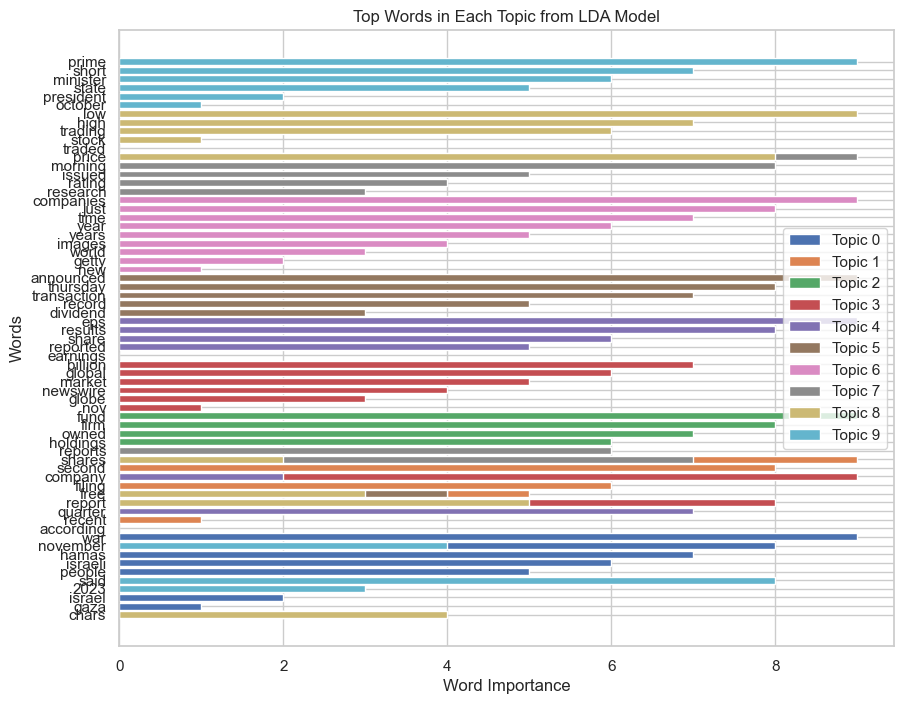

In [47]:
# Setting the aesthetic style of the plots
sns.set(style='whitegrid')

# Creating a figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Plotting the top words for each topic
for i, words in topics.items():
    ax.barh(words, range(len(words)), label=f'Topic {i}')

ax.set_xlabel('Word Importance')
ax.set_ylabel('Words')
ax.set_title('Top Words in Each Topic from LDA Model')
ax.legend()

plt.show()



`The top words in each topic are:` 


- 0: ['chars', 'gaza', 'israel', '2023', 'said', 'people', 'israeli', 'hamas', 'november', 'war'], 
- 1: ['according', 'recent', 'chars', 'quarter', 'report', 'free', 'filing', 'company', 'second', 'shares'], 
- 2: ['free', 'report', 'chars', 'shares', 'reports', 'quarter', 'holdings', 'owned', 'firm', 'fund'], 
- 3: ['2023', 'nov', 'chars', 'globe', 'newswire', 'market', 'global', 'billion', 'report', 'company'], 
- 4: ['earnings', 'chars', 'company', 'report', 'free', 'reported', 'share', 'quarter', 'results', 'eps'],
- 5: ['november', 'chars', 'report', 'dividend', 'free', 'record', 'reports', 'transaction', 'thursday', 'announced'], 
- 6: ['chars', 'new', 'getty', 'world', 'images', 'years', 'year', 'time', 'just', 'companies'], 
- 7: ['report', 'free', 'chars', 'research', 'rating', 'issued', 'reports', 'shares', 'morning', 'price'], 
- 8: ['traded', 'stock', 'shares', 'free', 'chars', 'report', 'trading', 'high', 'price', 'low'], 
- 9: ['chars', 'october', 'president', '2023', 'november', 'state', 'minister', 'short', 'said', 'prime

## Actionable Insights and Recommendations 

### Actionable Insights

- ETFDaily, Globenewswire and Globalsecurity.org are the websites with the largest number of news articles.
✓
- All Africa, CNN, The verge are the websites with the smallest number of articles.
✓
- ETFdaily, globalnewswire and global security org have the highest number of visitors traffic
✓
- Allafrica, bbc and the verge have the least number of visitors traffic.
✓
- US, UK, Italy is where most media companies originate from.
✓
- Most articles mention US followed by Canada.
✓
- Globenewswire seems to be a site that mentions US, UK, Africa, Middle East relatively frequently.
✓
- AlJazeera mentions Middle East in its articles quite a lot.
✓
- Distribution of message length by website domain does not vary much, however there are some outliers.
✓
- The top 5 keywords are: chars, report, free, 2023 and according.
✓
- An average cosine similarity score of 0.026437723399909175, indicates a very low degree of similarity between the vectors being compared.
✓
- Keywords in the headline/title are not that similar compared to keywords in the news body across sites
✓
- The top words in each topic are:`
o
0: ['chars', 'gaza', 'israel', '2023', 'said', 'people', 'israeli', 'hamas', 'november', 'war'],
o
1: ['according', 'recent', 'chars', 'quarter', 'report', 'free', 'filing', 'company', 'second', 'shares'],
o
2: ['free', 'report', 'chars', 'shares', 'reports', 'quarter', 'holdings', 'owned', 'firm', 'fund'],
o
3: ['2023', 'nov', 'chars', 'globe', 'newswire', 'market', 'global', 'billion', 'report', 'company'],
o
4: ['earnings', 'chars', 'company', 'report', 'free', 'reported', 'share', 'quarter', 'results', 'eps'],
o
5: ['november', 'chars', 'report', 'dividend', 'free', 'record', 'reports', 'transaction', 'thursday', 'announced'],
o
6: ['chars', 'new', 'getty', 'world', 'images', 'years', 'year', 'time', 'just', 'companies'],
o
7: ['report', 'free', 'chars', 'research', 'rating', 'issued', 'reports', 'shares', 'morning', 'price'],
o
8: ['traded', 'stock', 'shares', 'free', 'chars', 'report', 'trading', 'high', 'price', 'low'],
o
9: ['chars', 'october', 'president', '2023', 'november', 'state', 'minister', 'short', 'said', 'prime